# toledowalleye - stlr features
* StelllarAlgo Data Science
* Ryan Kazmerik & Nakisa Rad
* Feb 25, 2022

## Hypothesis
The goal of this notebook is to compare the results of the model with the model using standard StellarAlgo features with the engineered retention model features.

## Experiment
This section details our experiment including querying data, data transformations, feature selection and modelling.

In [1]:
import getpass
import pyodbc
import pandas as pd
import warnings
import matplotlib.pyplot as plt

from pycaret.classification import *

warnings.filterwarnings('ignore')

### Let's connect to MSSQL and run a stored proc to get our dataset:

In [2]:
# connect to SQL Server.
SERVER = '34.206.73.189'  
DATABASE = 'datascience' 
USERNAME = 'nrad' 
PASSWORD = getpass.getpass(prompt='Enter your password')
CNXN = pyodbc.connect('DRIVER={ODBC Driver 17 for SQL Server};SERVER='+SERVER+';DATABASE='+DATABASE+';UID='+USERNAME+';PWD='+ PASSWORD)

In [3]:
lkupclientid = 52 # toledowalleye
cursor = CNXN.cursor()

storedProc = (
    f"""Exec [stlrAHL].[ds].[getRetentionScoringModelData] {lkupclientid}"""
)

df = pd.read_sql(storedProc, CNXN)

# apply some data transformations
df["year"] = pd.to_numeric(df["year"])

CNXN.commit()
cursor.close()

df.shape

(7853, 54)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7853 entries, 0 to 7852
Data columns (total 54 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   lkupClientId            7853 non-null   int64  
 1   dimCustomerMasterId     7853 non-null   int64  
 2   customerNumber          7851 non-null   object 
 3   year                    7853 non-null   int64  
 4   productGrouping         7853 non-null   object 
 5   totalSpent              7853 non-null   float64
 6   recentDate              7853 non-null   object 
 7   attendancePercent       7853 non-null   float64
 8   renewedBeforeDays       7853 non-null   int64  
 9   isBuyer                 7853 non-null   object 
 10  source_tenure           7853 non-null   int64  
 11  tenure                  7853 non-null   int64  
 12  distToVenue             7853 non-null   float64
 13  totalGames              7853 non-null   int64  
 14  recency                 7853 non-null   

### We should specify the features used in our model:

In [5]:
# choose the features for the stellar base retention model
features = [
    "dimCustomerMasterId",
                "attendancePercent",
                "distToVenue",
                "missed_games_1",
                "missed_games_2",
                "missed_games_over_2",
                "totalSpent",
                "recency",
                "source_tenure",
                "renewedBeforeDays",
                "isNextYear_Buyer",
                "productGrouping",
                "year"
]

# copy your main dataframe
df_dataset = df

# choose the features & train year & test year
df_dataset = df_dataset[features]
df_dataset["year"] = pd.to_numeric(df_dataset["year"])
df_dataset = df_dataset.loc[df_dataset["year"] <= 2019]

df_train = df_dataset.sample(frac=0.85, random_state=786)
df_eval = df_dataset.drop(df_train.index)

df_train.reset_index(drop=True, inplace=True)
df_eval.reset_index(drop=True, inplace=True)

# print out the number of records for training and eval
print('Data for Modeling: ' + str(df_train.shape))
print('Unseen Data For Predictions: ' + str(df_eval.shape), end="\n\n")

Data for Modeling: (4750, 13)
Unseen Data For Predictions: (838, 13)



### Now we can model the data using a binary classification prediction for the isnextyear_buyer field to see how likely a customer is to re-purchase.

In [6]:
setup(
    data= df_train, 
    target="isNextYear_Buyer", 
    train_size = 0.85,
    data_split_shuffle=True,
    ignore_features=["dimCustomerMasterId","productGrouping","year"],
    silent=True,
    verbose=False,
    numeric_features=[
    "attendancePercent",
                "distToVenue",
                "missed_games_1",
                "missed_games_2",
                "missed_games_over_2",
                "totalSpent",
                "recency",
                "source_tenure",
                "renewedBeforeDays"
    ]
);

In [7]:
model_matrix = compare_models(
    fold=10,
    include=["lr", "xgboost"]
)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
xgboost,Extreme Gradient Boosting,0.7855,0.8584,0.7340,0.7058,0.7188,0.5456,0.5467,0.3360
lr,Logistic Regression,0.6532,0.7335,0.3673,0.5572,0.4411,0.2053,0.2154,0.3940


In [8]:
best_model = create_model(model_matrix)
final_model = finalize_model(best_model)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7574,0.8490,0.7105,0.6667,0.6879,0.4898,0.4905
1,0.7995,0.8475,0.8013,0.7035,0.7492,0.5834,0.5868
2,0.7698,0.8410,0.6556,0.7071,0.6804,0.5009,0.5018
3,0.7946,0.8734,0.7550,0.7125,0.7331,0.5663,0.5670
4,0.7995,0.8642,0.7616,0.7188,0.7395,0.5768,0.5774
5,0.7921,0.8776,0.7351,0.7161,0.7255,0.5582,0.5583
6,0.7797,0.8595,0.6821,0.7153,0.6983,0.5250,0.5253
7,0.7990,0.8635,0.7483,0.7244,0.7362,0.5739,0.5741
8,0.7940,0.8658,0.7219,0.7267,0.7243,0.5599,0.5599
9,0.7692,0.8421,0.7682,0.6667,0.7138,0.5221,0.5258


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Py

### Let's load in our 2021 season data and get retention scores using the model:

In [9]:
df_inference = df.loc[df["year"] >= 2021]
df_inference = df_inference.fillna(0)
df_inference.shape

(2265, 54)

In [10]:
new_predictions = predict_model(final_model, data=df_inference, raw_score=True)
new_predictions.head()

,lkupClientId,dimCustomerMasterId,customerNumber,year,productGrouping,totalSpent,recentDate,attendancePercent,renewedBeforeDays,isBuyer,...,education,urbanicity,credits_after_refund,is_Lockdown,NumberofGamesPerSeason,CNTPostponedGames,isNextYear_Buyer,Label,Score_0,Score_1
5588,52,166,1040985,2021,Partial Season,720.0,2022-04-16,1.454545,64,TRUE,...,0,0,0.0,1,53,0,0,0,0.9615,0.0385
5589,52,301,1043291,2021,Partial Season,432.0,2022-04-02,1.285714,3,TRUE,...,0,0,0.0,1,53,0,0,0,0.9889,0.0111
5590,52,351,1620791,2021,Full Season,0.0,2022-04-16,1.700000,12,FALSE,...,0,0,0.0,1,53,0,0,0,0.9993,0.0007
5591,52,628,1037236,2021,Full Season,120.0,2021-12-31,1.000000,87,TRUE,...,0,0,0.0,1,53,0,0,0,0.9312,0.0688
5592,52,633,1033171,2021,Partial Season,384.0,2022-03-26,1.600000,59,TRUE,...,0,0,0.0,1,53,0,0,0,0.9569,0.0431


In [11]:
new_predictions["Label"].value_counts()

0    2261
1       4
Name: Label, dtype: int64

In [12]:
new_predictions["Score_1"].value_counts(bins=[0, 0.2, 0.4, 0.6, 0.8, 1.0])

(-0.001, 0.2]    2214
(0.2, 0.4]         45
(0.4, 0.6]          6
(0.6, 0.8]          0
(0.8, 1.0]          0
Name: Score_1, dtype: int64

array([[<AxesSubplot:title={'center':'Score_1'}>]], dtype=object)

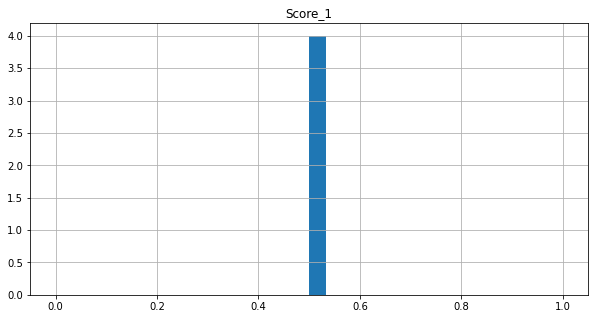

In [13]:
new_predictions[new_predictions["Label"]==1][["Score_1"]].hist(bins=30, figsize=(10,5), range=[0,1])

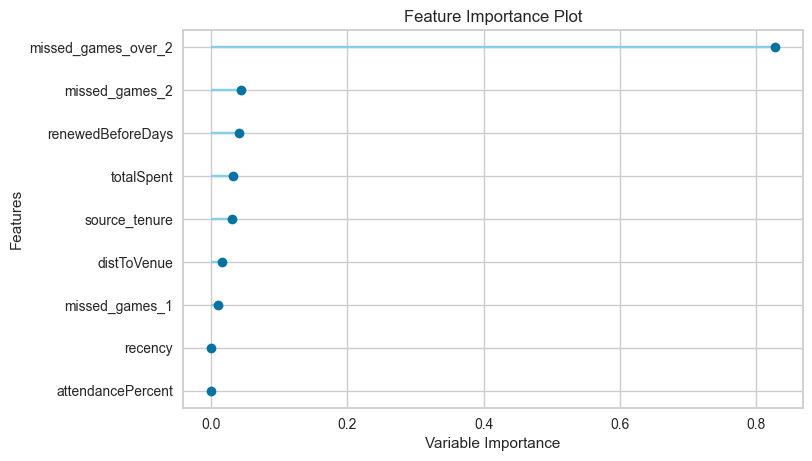

In [14]:
plot_model(best_model, plot='feature')

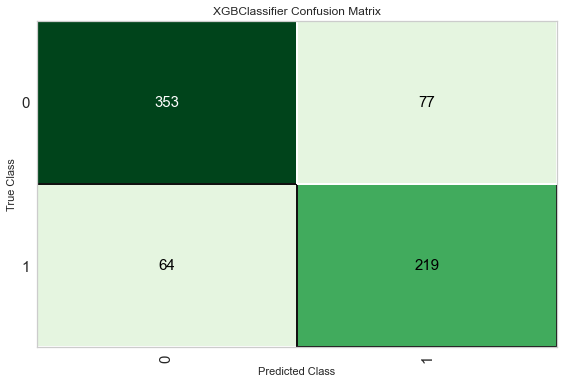

In [15]:
plot_model(best_model, plot='confusion_matrix')

## Observations
Here you can document some ideas on the results from above


## Conclusions
Here you can talk about next steps, did the experiment work? If yes, what to do next? If no, why?